# Exploring the demonstration models

This notebook shows several standard ways to interact with the demonstrations stored into the exp/run directories. 

In [1]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import cv2

import matplotlib.pyplot as plt
import random
import torch
import json

import pathlib
from demonstration import Demonstration

In [2]:
experiment = "demonstration"
run = "freeform"

exp = Config().get_experiment(experiment, run)

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\freeform_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/freeform successfully loaded


### Read out all the demonstrations from a run

In [3]:
# read out all the demonstrations from a run
demos = [item.name for item in exp.data_dir().iterdir() if item.is_dir()]
print(demos)

['2024_12_26__16_40_20', '2024_12_26__16_44_06']


### Interactively select a demonstration from a run

In [4]:
# cell for: interactively select a demonstration from a run
demodirs = [item for item in exp.data_dir().iterdir() if item.is_dir()]
demos_dict = {}
for i, t in enumerate(demodirs):
    demos_dict[i] = t
print("A pop up dialog will appear now. Enter the number of demonstration.")
for key in demos_dict:
    print(f"\t{key}: {demos_dict[key].name}")
# FIXME: for easier debugging
# inpval = input("Choose the demonstration: ")
inpval = "0"
# print(inpval)
if inpval:
    demo_id = int(inpval)
    if demo_id in demos_dict:
        demo_dir = demos_dict[demo_id]
        print(f"You chose demonstration: {demo_dir.name}")
    else:
        print(f"No such demo: {demo_id}")


A pop up dialog will appear now. Enter the number of demonstration.
	0: 2024_12_26__16_40_20
	1: 2024_12_26__16_44_06
You chose demonstration: 2024_12_26__16_40_20


###  Read out all the pictures in the demonstration

FIXME: I had redone this from scratch, but should have used the demonstration_helper and there was something called analyze demo...

Put them together. All these functions should take the experiment. 

{'cameras': ['dev2'],
 'demo': '2024_12_26__16_40_20',
 'demo_dir': WindowsPath('c:/Users/lboloni/Documents/Code/_TempData/BerryPicker-experiments/demonstration/freeform/2024_12_26__16_40_20'),
 'exp': Experiment: {'experiment_name': 'demonstration', 'name': 'freeform', 'run_name': 'freeform', 'exp_run_sys_indep_file': 'C:\\Users\\lboloni\\Documents\\Code\\_Checkouts\\BerryPicker\\src\\experiment_configs\\demonstration\\freeform.yaml', 'data_dir': 'c:\\Users\\lboloni\\Documents\\Code\\_TempData\\BerryPicker-experiments\\demonstration\\freeform', 'subrun_name': None, 'time_started': '2025-05-12 13:57:29'},
 'maxsteps': 596}
Cameras found: ['dev2']
There are 596 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']


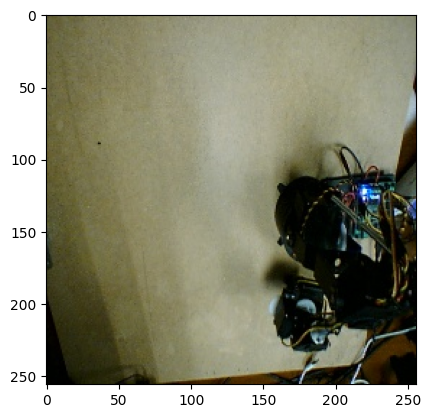

In [5]:
demo = Demonstration(exp, demo_dir.name)
print(demo)
print(f"Cameras found: {demo.cameras}")
print(f"There are {demo.maxsteps} steps in this demonstration")
print(f"This demonstration was recorded by the following cameras: {demo.cameras}")

# pick and show a random image from a random camera
cam = random.choice(demo.cameras)
imgno = random.randint(0, demo.maxsteps)
sensor_readings, image = demo.get_image(imgno, camera=cam)

fig, ax = plt.subplots()
ax.imshow(image)


# Move all the figures to a video

In [6]:
cam = demo.cameras[0]
video_path = pathlib.Path(demo.demo_dir, f"video_{cam}.mp4")


In [7]:

fps = 10
width = 256
height = 256

# Initialize video writer

if not video_path.exists():

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    for i in range(demo.maxsteps):
        img_path = demo.get_image_path(i, camera=cam)
        frame = cv2.imread(str(img_path))
        out.write(frame)

    out.release()


In [8]:
from sensorprocessing.sp_helper import load_capture_to_tensor

imgno = random.randint(0, demo.maxsteps)

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, imgno)
ret, frame = cap.read()
if ret:
    # CV2 reads by default in BGR... 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # cv2.imwrite(output_image, frame)    
    image_to_process, image_to_show = load_capture_to_tensor(frame, transform=None)
else:
    print(f"Could not read frame {imgno}")
cap.release()

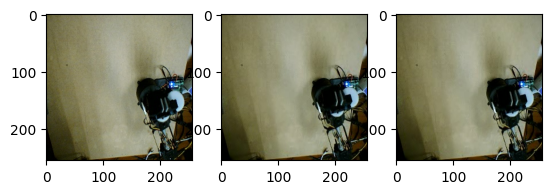

In [9]:
sensor_readings, image = demo.get_image(imgno, camera=cam)

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
ax1.imshow(image)
ax3.imshow(frame)
ax2.imshow(image_to_show)


In [15]:
# print(sensor_readings == image_to_process)
# print(sensor_readings == sensor_readings)
a = image_to_process
b = sensor_readings
print(torch.allclose(image_to_process.float(), sensor_readings.float(), atol=0.5))

False


In [20]:
a.shape
a[0][2][100][:]

tensor([0.1765, 0.1804, 0.1765, 0.2235, 0.1882, 0.2039, 0.2235, 0.2157, 0.2157,
        0.2235, 0.2353, 0.2039, 0.2235, 0.2039, 0.2157, 0.2235, 0.2471, 0.2510,
        0.2667, 0.2824, 0.2745, 0.2588, 0.2510, 0.2588, 0.2667, 0.2706, 0.2784,
        0.2745, 0.2902, 0.3059, 0.2941, 0.2941, 0.2706, 0.2980, 0.2941, 0.2941,
        0.3216, 0.3216, 0.3137, 0.3412, 0.3216, 0.3216, 0.3216, 0.3333, 0.3294,
        0.3490, 0.3333, 0.3490, 0.3686, 0.3686, 0.3843, 0.3882, 0.3725, 0.3725,
        0.3843, 0.3725, 0.3765, 0.3725, 0.3765, 0.3922, 0.3922, 0.3922, 0.3843,
        0.3843, 0.4078, 0.4118, 0.4196, 0.4235, 0.4235, 0.4196, 0.4118, 0.4078,
        0.4000, 0.4078, 0.4157, 0.4235, 0.4235, 0.4196, 0.4157, 0.4118, 0.4314,
        0.4353, 0.4353, 0.4431, 0.4431, 0.4431, 0.4431, 0.4431, 0.4353, 0.4471,
        0.4549, 0.4549, 0.4431, 0.4510, 0.4510, 0.4353, 0.4431, 0.4431, 0.4510,
        0.4510, 0.4667, 0.4824, 0.4941, 0.4902, 0.5059, 0.5255, 0.5098, 0.5294,
        0.5451, 0.5490, 0.5216, 0.5294, 

In [21]:
b.shape
b[0][2][100][:]

tensor([0.1804, 0.1490, 0.2039, 0.2314, 0.2471, 0.2078, 0.2314, 0.2353, 0.2353,
        0.2667, 0.2471, 0.2510, 0.2235, 0.2078, 0.2196, 0.2510, 0.2627, 0.2471,
        0.2745, 0.2627, 0.2902, 0.2784, 0.2863, 0.2863, 0.2745, 0.2745, 0.2863,
        0.2784, 0.3059, 0.3137, 0.3020, 0.2980, 0.2863, 0.2784, 0.2941, 0.3020,
        0.3216, 0.3412, 0.3608, 0.3529, 0.3490, 0.3490, 0.3412, 0.3490, 0.3412,
        0.3843, 0.3647, 0.3647, 0.3569, 0.3608, 0.4000, 0.4235, 0.4000, 0.3804,
        0.3765, 0.3804, 0.3686, 0.3725, 0.3843, 0.3922, 0.3961, 0.3961, 0.3490,
        0.3882, 0.3882, 0.4078, 0.4000, 0.3686, 0.3608, 0.3647, 0.3922, 0.3765,
        0.3804, 0.3922, 0.4275, 0.4549, 0.4196, 0.4235, 0.4118, 0.4039, 0.4157,
        0.4392, 0.4353, 0.4353, 0.4431, 0.4353, 0.4471, 0.4510, 0.4824, 0.4627,
        0.4627, 0.4588, 0.4627, 0.4667, 0.4588, 0.4078, 0.4588, 0.4784, 0.4706,
        0.4902, 0.4980, 0.5137, 0.5098, 0.5176, 0.5098, 0.5333, 0.5490, 0.5647,
        0.5451, 0.5373, 0.5020, 0.5451, 

In [22]:
a-b

tensor([[[[-0.0039, -0.0275, -0.0196,  ..., -0.0078, -0.0078,  0.0000],
          [-0.0275, -0.0118, -0.0275,  ..., -0.0157, -0.0118,  0.0000],
          [-0.0157, -0.0275, -0.0510,  ..., -0.0235, -0.0118,  0.0039],
          ...,
          [-0.0078, -0.0118, -0.0039,  ..., -0.0039,  0.0000,  0.0000],
          [-0.0039, -0.0118, -0.0078,  ..., -0.0039,  0.0000,  0.0000],
          [ 0.0000, -0.0118, -0.0078,  ..., -0.0078,  0.0000,  0.0000]],

         [[ 0.0078, -0.0157, -0.0078,  ..., -0.0039, -0.0039,  0.0039],
          [-0.0157,  0.0000, -0.0157,  ..., -0.0118, -0.0078,  0.0039],
          [-0.0039, -0.0157, -0.0471,  ..., -0.0196, -0.0039,  0.0078],
          ...,
          [-0.0078, -0.0078, -0.0078,  ...,  0.0039, -0.0039, -0.0039],
          [-0.0039, -0.0078, -0.0118,  ...,  0.0078, -0.0039,  0.0000],
          [ 0.0000, -0.0078, -0.0118,  ...,  0.0039, -0.0039, -0.0039]],

         [[ 0.0353,  0.0118,  0.0118,  ...,  0.0039,  0.0039,  0.0118],
          [ 0.0118,  0.0275,  